Підключаємо бібліотеки Pillow, Numpy та Matplotlib

In [18]:
from PIL import Image
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import copy
from sklearn import metrics
import scipy.spatial.distance as dst
import math

In [19]:
N = 100
size = N, N

Засобами бібліотеки Pillow(Python Image Library) в циклі завантажуємо зображення текстур з базової директорії, та встановлюємо їх деталізацію на рівні 100x100, після чого трансформуємо у формат масиву numpy. 

In [23]:
pil_imgs = [Image.open('Bark1.jpg'), 
            Image.open('Stone2.jpg'), 
            Image.open('Grass2.jpg')]
for image in pil_imgs:
    image.thumbnail(size)

1. bark
2. stone
3. grass

In [26]:
images = np.array([np.array(val) for val in pil_imgs])

Таким чином в images зберігаються зображення у вигляді матриці пікселів. Кожен піксель представлений масивом з 3 цілих чисел, що є кольоровими компонентами. 

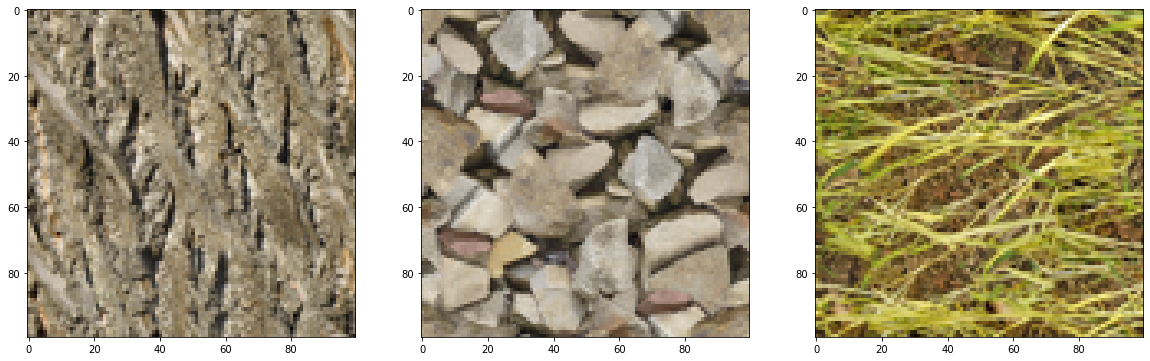

In [27]:
fig, axes = plt.subplots(1,3)

for i, ax in enumerate(axes):
    ax.imshow(images[i])
fig.set_figwidth(20)
fig.set_figheight(20)
plt.show()

In [6]:
centers = images.mean(axis=1)
centers[1].shape

(100, 3)

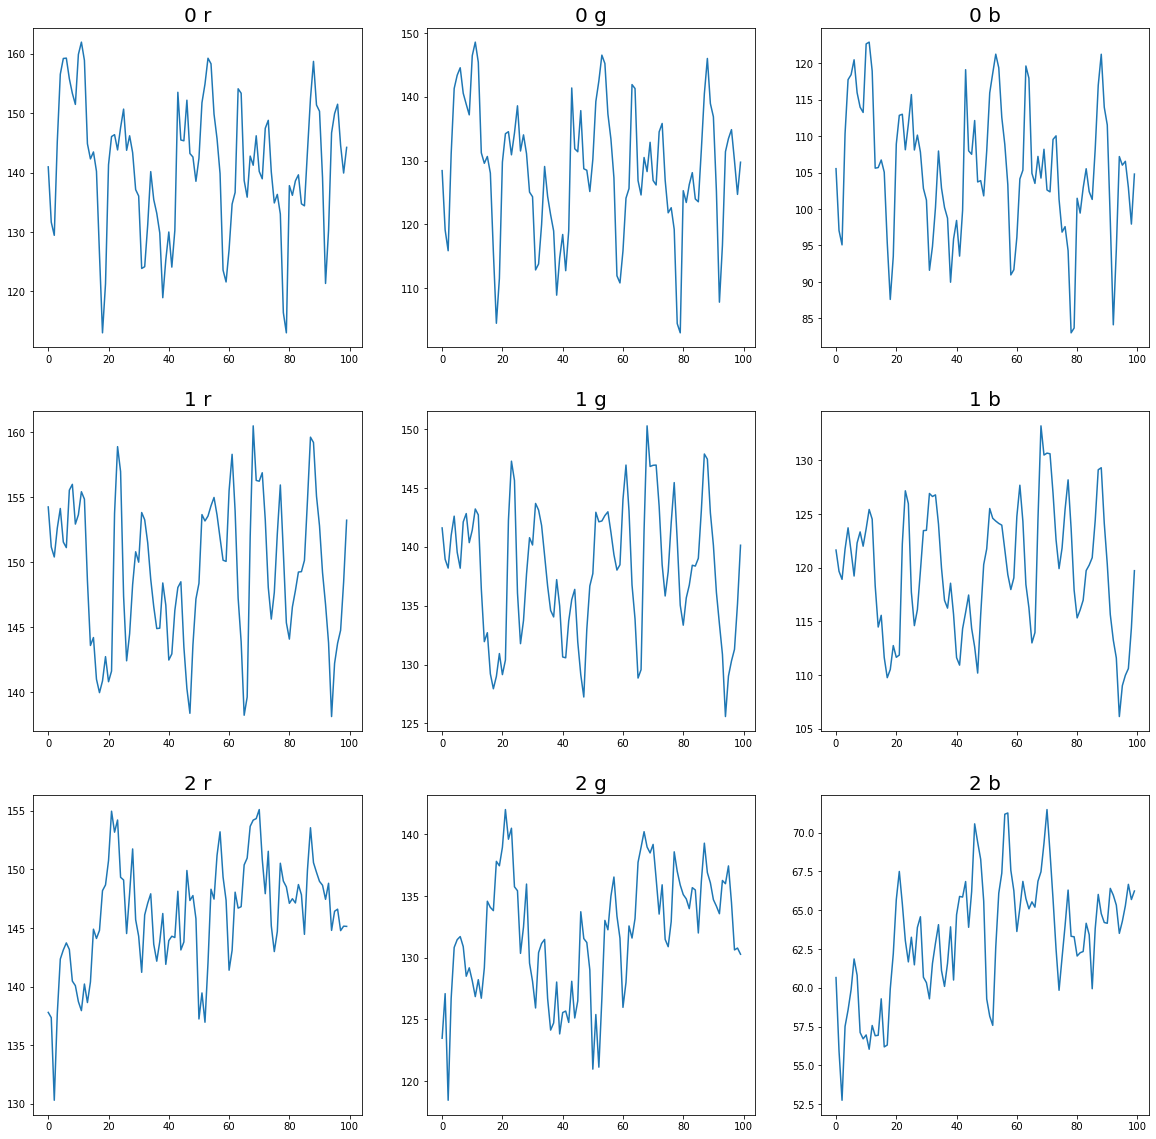

In [7]:
fig, axes = plt.subplots(3,3)
color = ['r','g','b']
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ax.plot(centers[i][:,j])
        ax.set_title(str(i)+" "+color[j],fontsize=20)
fig.set_figwidth(20)
fig.set_figheight(20)
plt.show()

Параметр для оптимізації поля контрольних допусків:

In [8]:
delta = 30

Як базовий клас оберемо bark <br/>
Визначаємо контрольні допуски щодо центру базового класу:

In [10]:
admission_top = centers[0] + delta
admission_bottom = centers[0] - delta

Реалізуємо функцію бінеаризації вхідних зображень, що є універсальною для rgb та монохромних зображень.

In [11]:
def binearize (image, top, bottom):
    result = np.empty_like(image)
    for i, rlz in enumerate(image):
        for j, value in enumerate(rlz):
            if len(result.shape) == 3:
                for k, v in enumerate(value):
                    result[i][j][k] = 1 if bottom[j][k] <= v and v <= top[j][k] else 0
            else:
                result[i][j] = 1 if bottom[i][j] <= value and value <= top[i][j] else 0
    return result

Бінеаризуємо всі класи відносно контрольних допусків:

In [12]:
binary = np.array([binearize(image, admission_top, admission_bottom) for image in images])

Виведення бінеарізованих матриць зображень

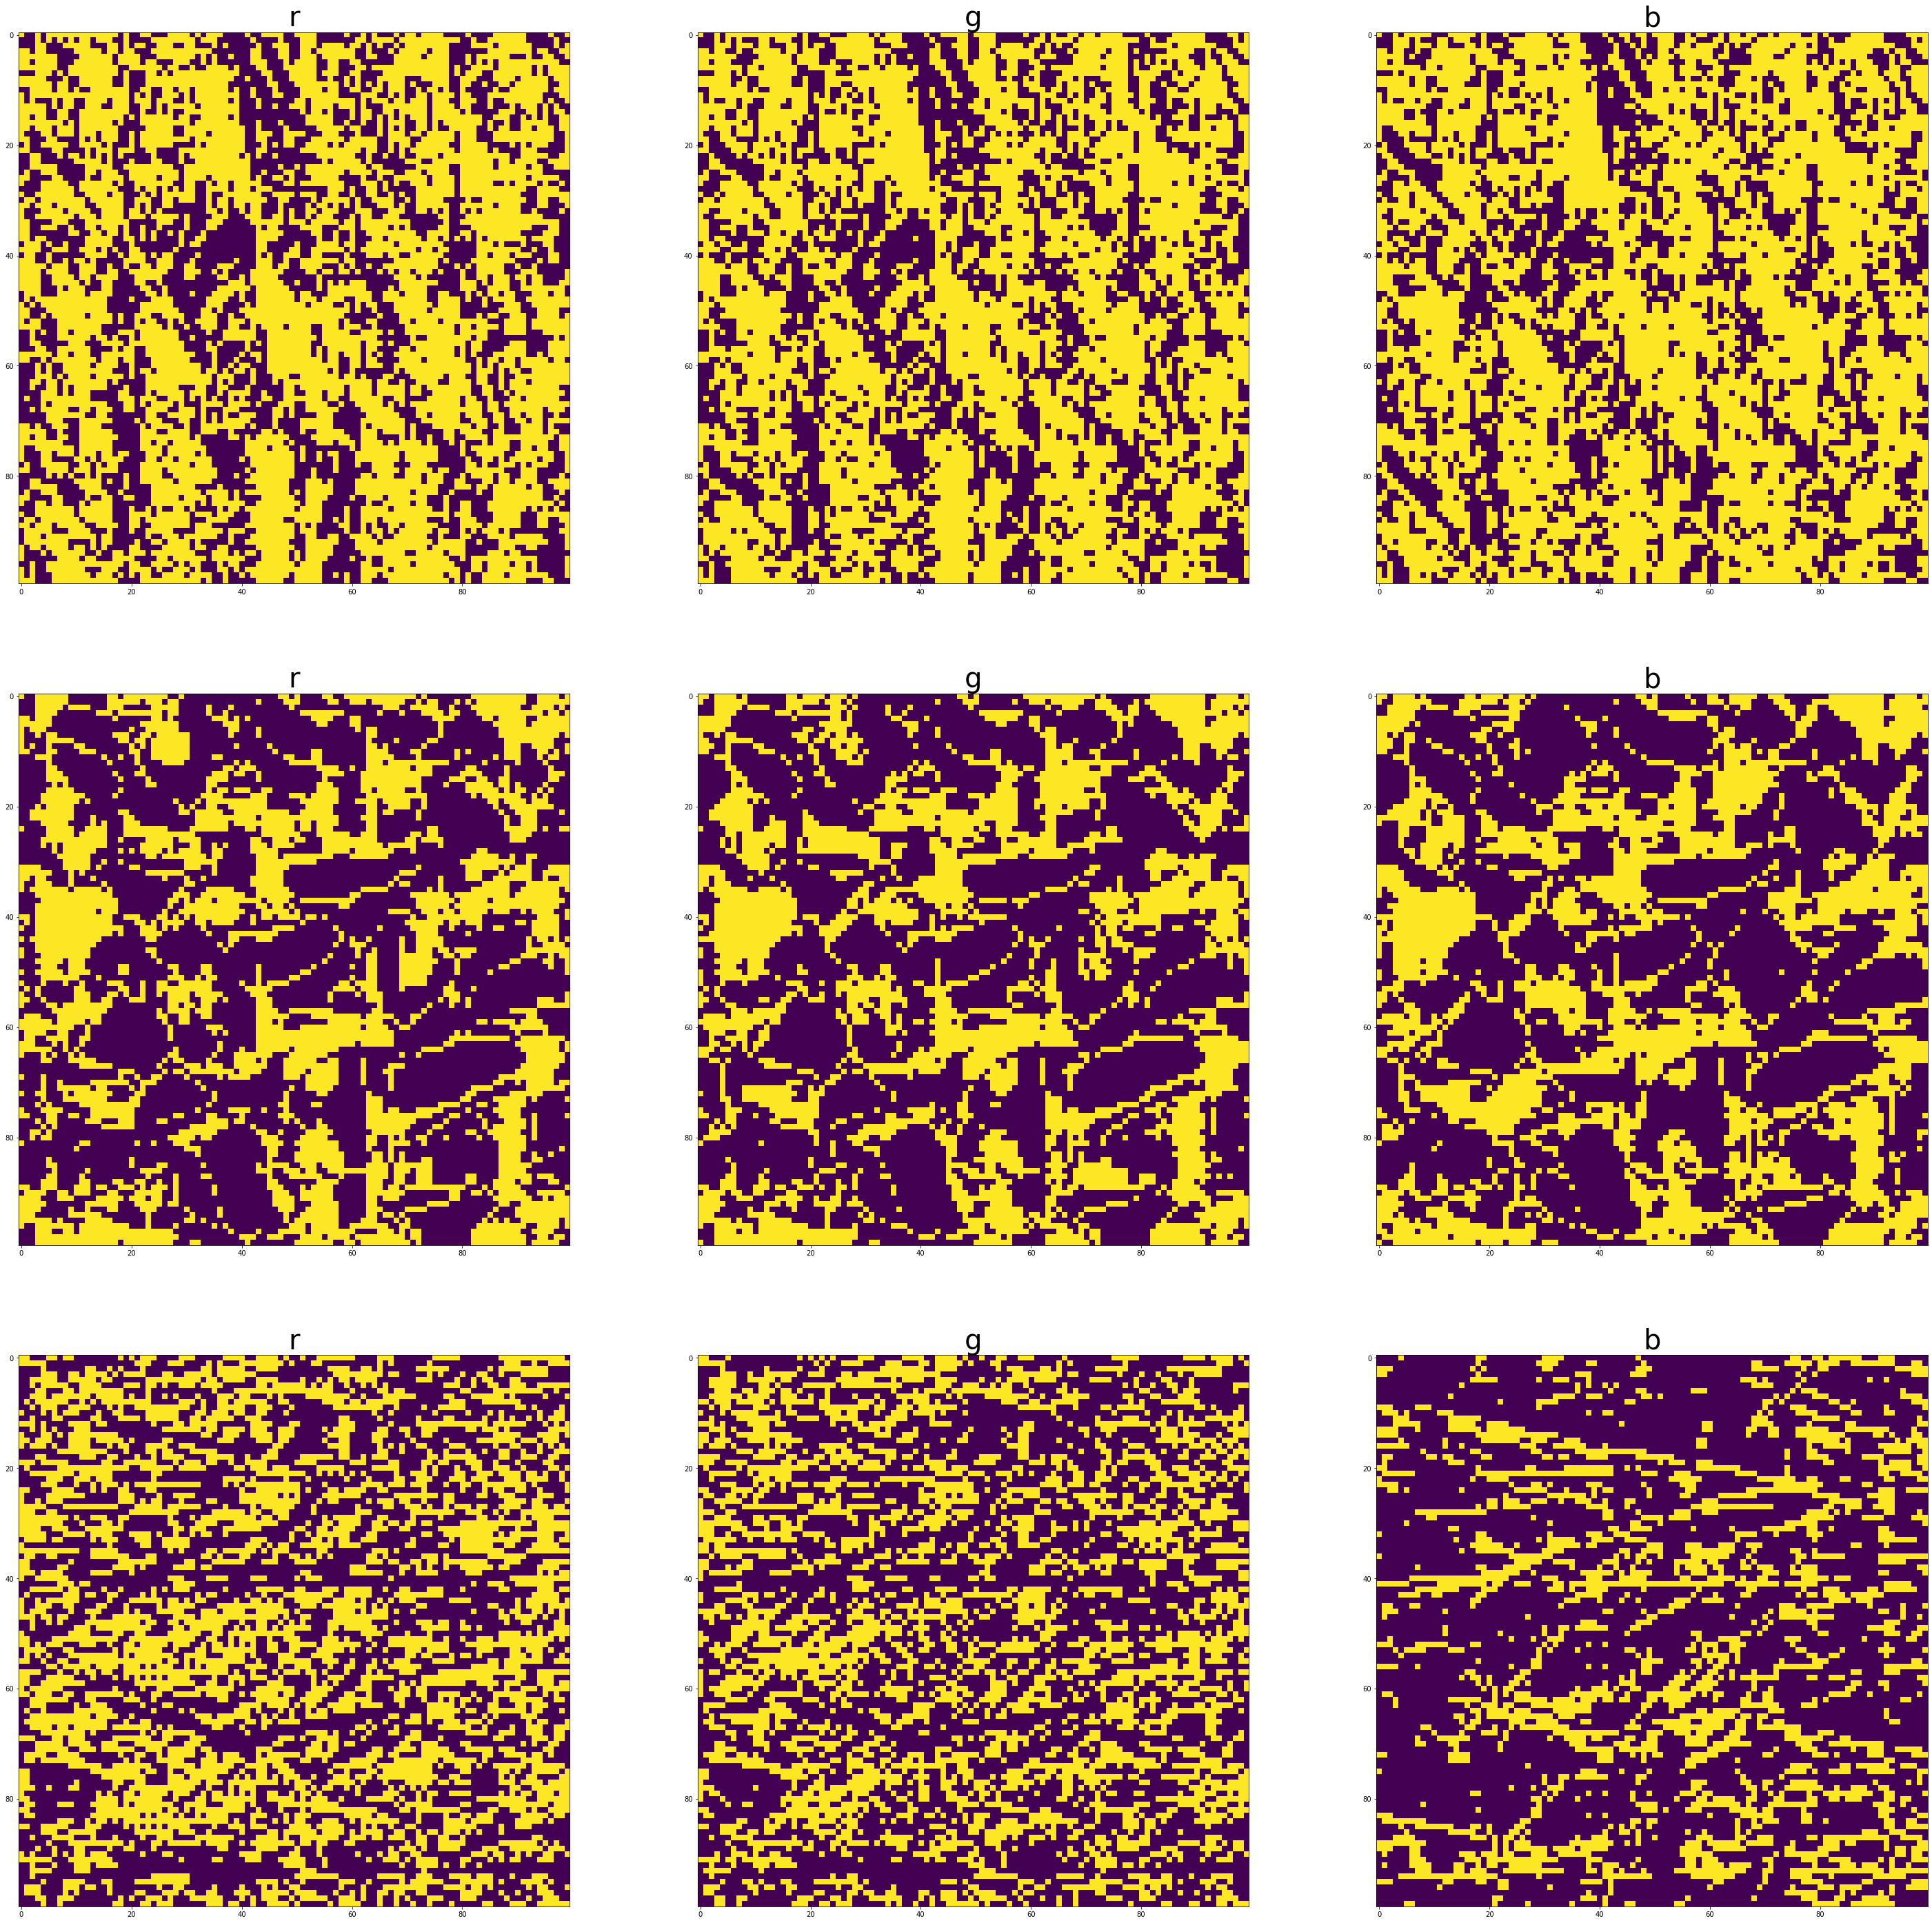

In [13]:
fig, axes = plt.subplots(3,3)

color = ['r','g','b']
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ax.imshow(binary[i,:,:,j])
        ax.set_title(color[j],fontsize=40)

fig.set_figwidth(50)
fig.set_figheight(50)
plt.show()

Параметр оптимізації рівня селекції, що використовується для визначення центрів бінаризованих масивів реалізацій класів: 

In [14]:
selection = 0.5
binary.shape

(3, 100, 100, 3)

Визначення центрів бінаризованих масивів реалізацій класів:

In [15]:
binearized_centers = (binary.mean(axis=1) > 0.5).astype(int)

In [16]:
binearized_centers[0].shape

(100, 3)

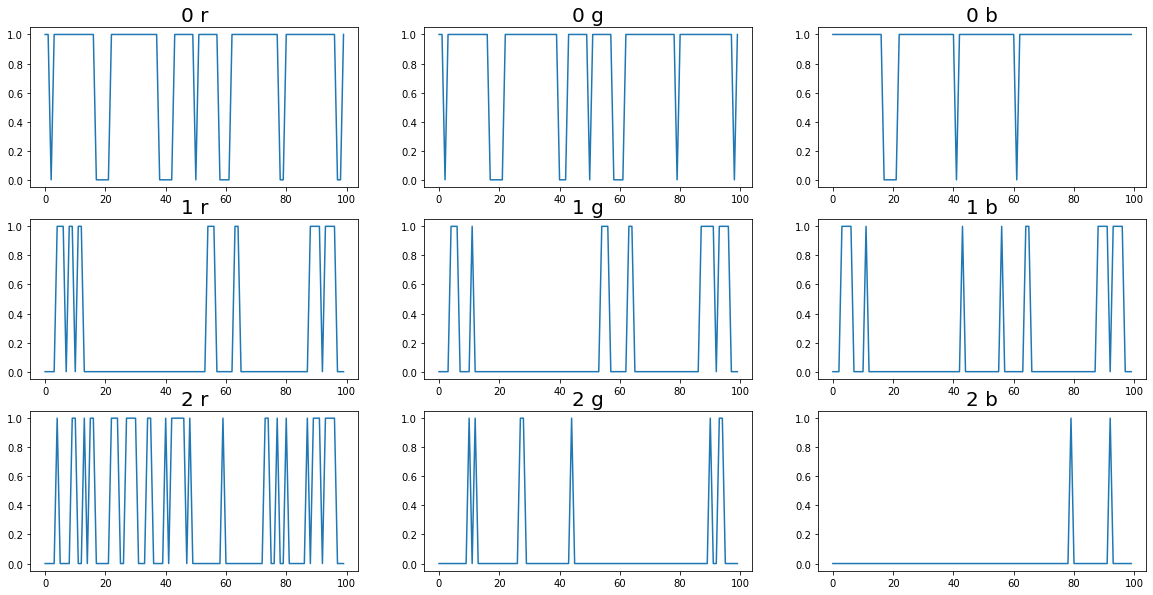

In [17]:
fig, axes = plt.subplots(3,3)

color = ['r','g','b']
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ax.plot(binearized_centers[i][:,j])
        ax.set_title(str(i) + " " +color[j],fontsize=20)


fig.set_figwidth(20)
fig.set_figheight(10)
plt.show()

Обрахунок відстані Хемінга для RGB:

In [30]:
def heming(arrA, arrB):
    A = arrA.reshape(-1)
    B = arrB.reshape(-1)
    result = 0
    for i,val in enumerate(A.T):
            result += 0 if val == B[i] else 1
    return result       

Формування масива відстаней Хемінга між центрами класів буде відбуватися у форматі

| Class from | to | to |
| --- | --- | --- |
| K0 | K1 | K2 |
| K1 | K0 | K2 |
| K2 | K0 | K1 |

Оскільки за базовий взято клас bark, то формується вирішальне правило, що буде відрізняти його реалізації від реалізацій інших класів еквівалентності

Визначаємо відстані від базового класу до сусідів

In [34]:
center_hems = np.array([heming(binearized_centers[0],v) for v in np.delete(binearized_centers, 0, axis=0)])

In [40]:
center_hems.shape

(2,)

In [49]:
print ("nearest neihbour: K" + str(np.where(center_hems == center_hems.min())[0][0]) + " with distance " + str(center_hems.min()))

nearest neihbour: K0 with distance 202


In [42]:
binearized_centers.shape
binary.shape

(3, 100, 100, 3)

Таким чином відстань від центру базового до центру найближчого класу в масиві має індекс 0, а за таблицею це означає, що найближчий сусід є K1 - stone.

Відстані Xемінга в Python словникy в форматі:

| Center | Realizations |
| --- | --- |
| C0 - K0 | C0 - K1 |
| C1 - K0 | C1 - K1 |


In [44]:
hems_center_reals = np.array([[np.array([heming(val, realization) for realization in v]) for v in np.delete(binary, 2, axis=0)]
                     for val in np.delete(binearized_centers, 2, axis=0)])

In [45]:
hems_center_reals.shape

(2, 2, 100)

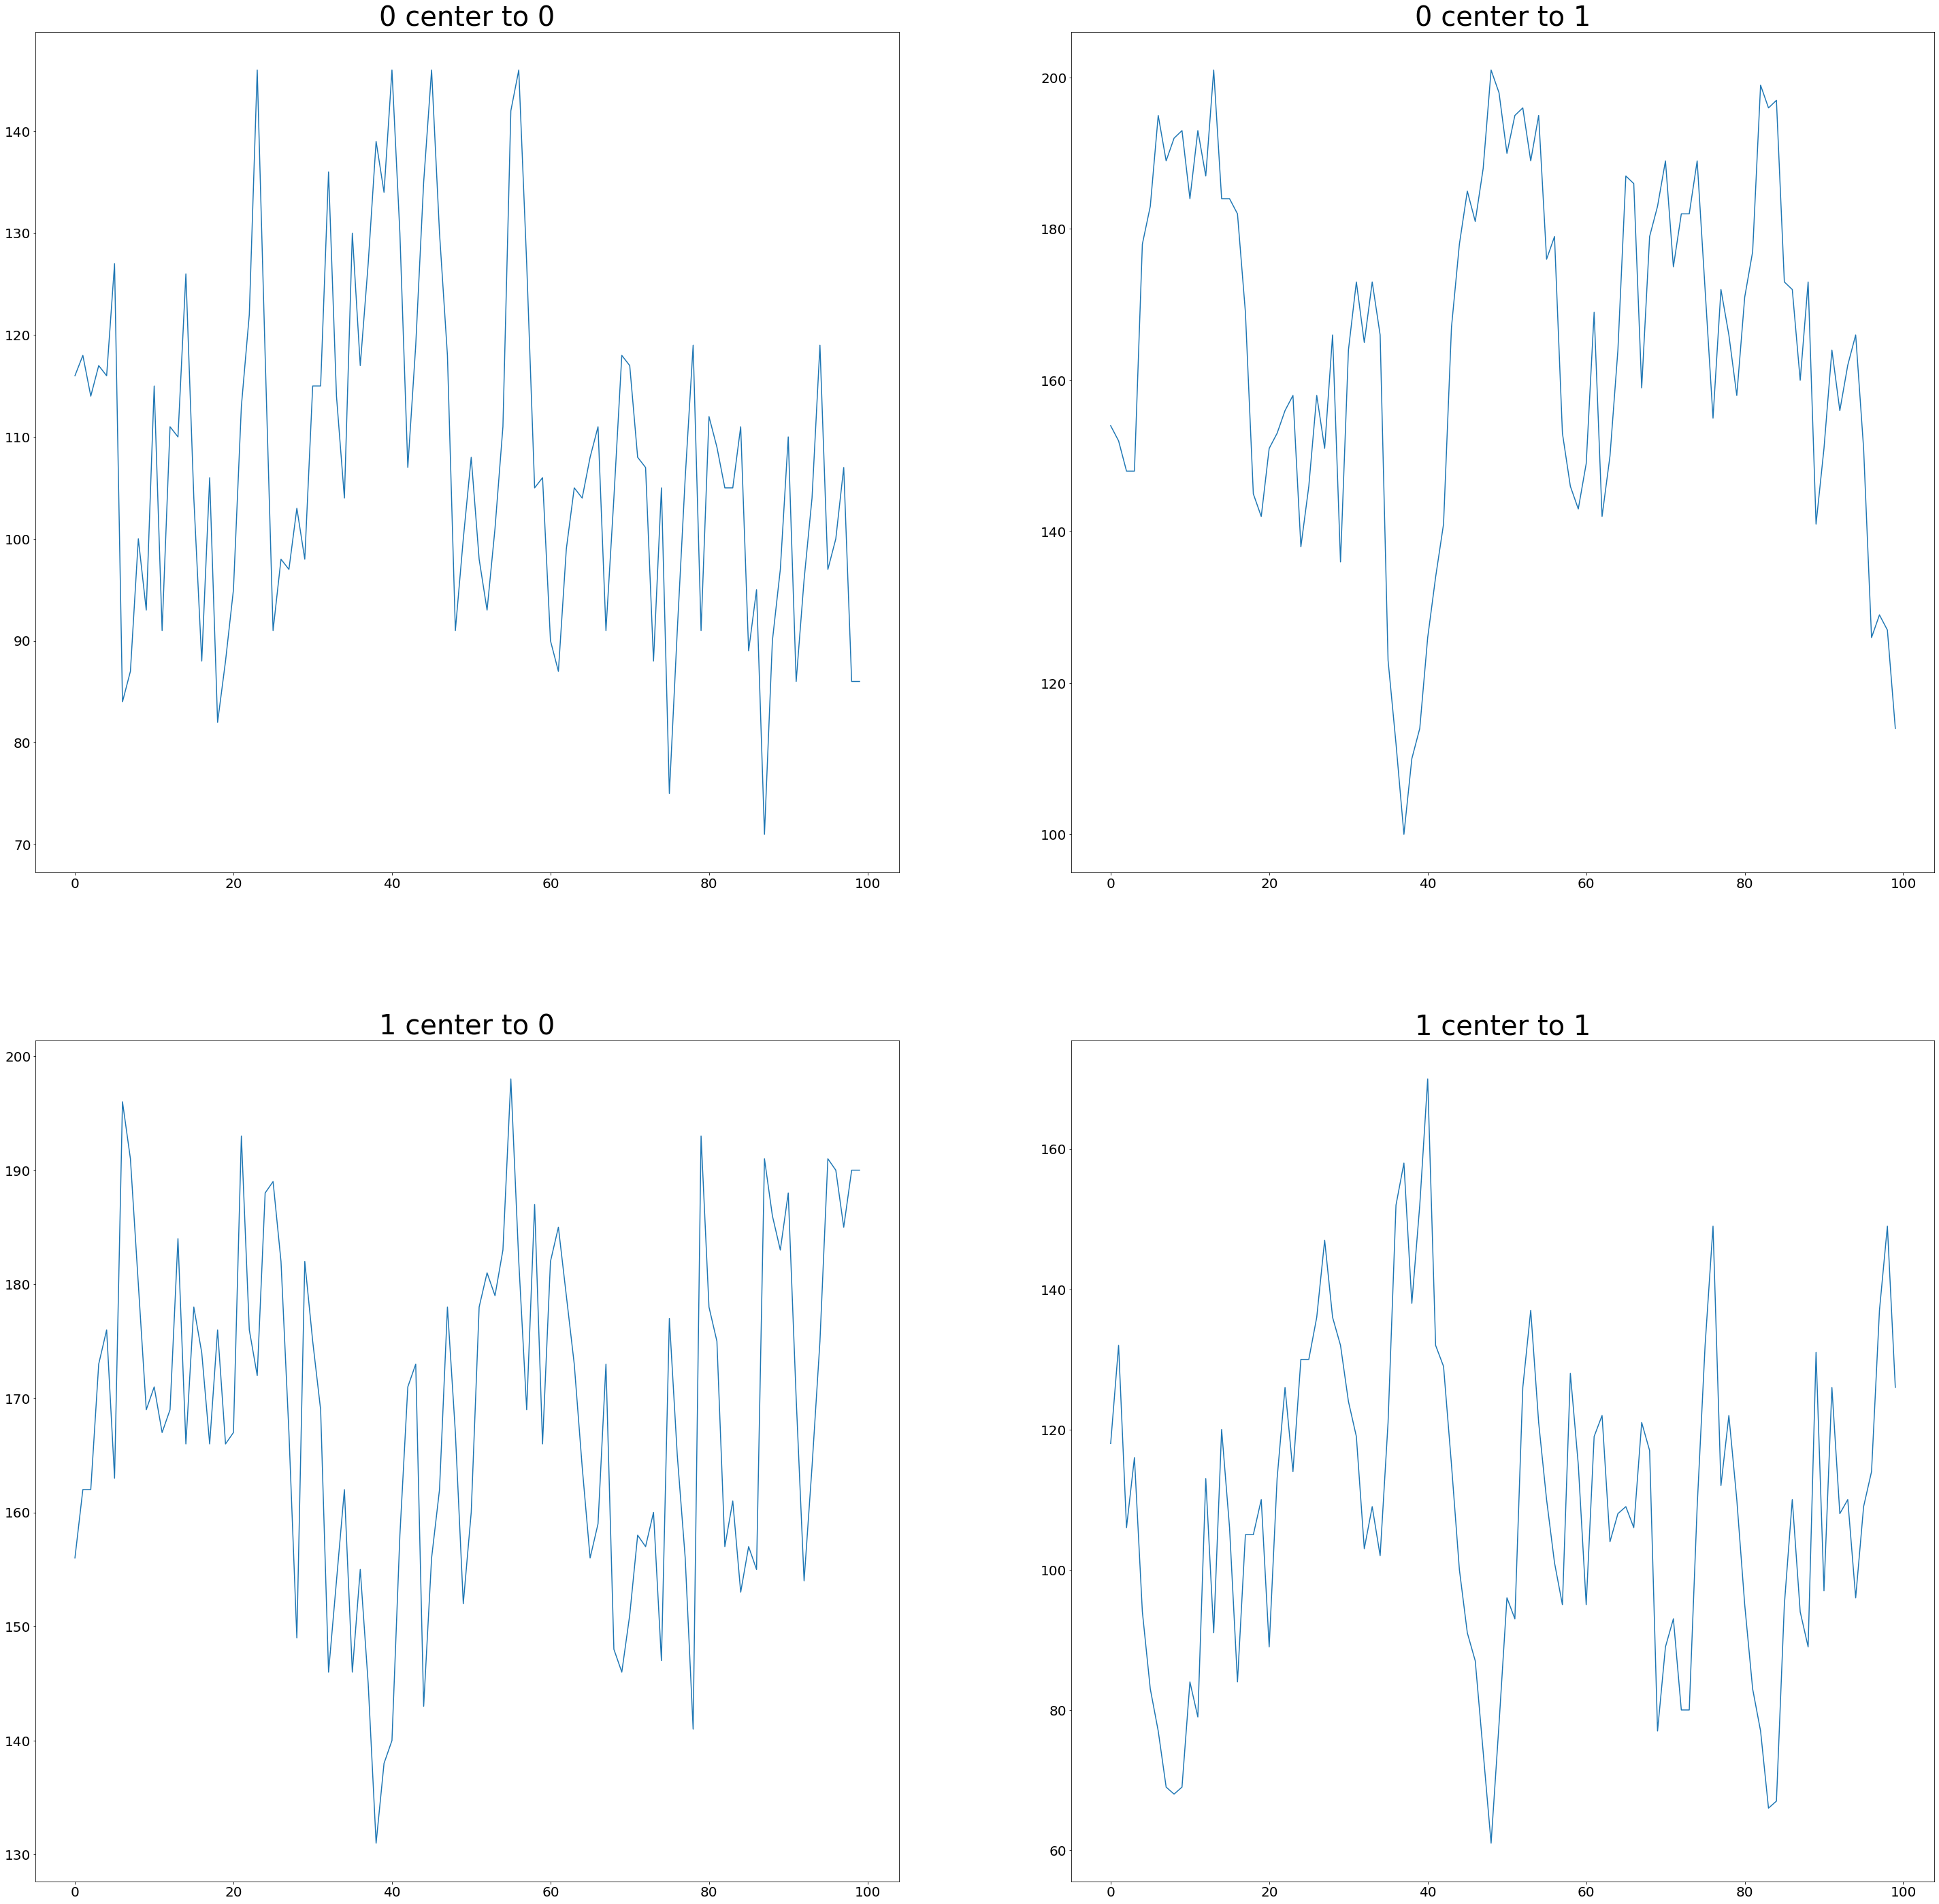

In [48]:
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20) 
fig, axes = plt.subplots(2,2)

color = ['r','g','b']
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ax.plot(hems_center_reals[i][j])
        ax.set_title(str(i)+" center to "+str(j),fontsize=40)
        
fig.set_figwidth(50)
fig.set_figheight(50)
plt.show()

Маючи відстані Хемінга між бінаризованими реалізаціями та центрами сусідніх класів, можемо перейти до оптимізації радіусу контейнеру:

In [56]:
maxK0 = hems_center_reals[0,0].max()
posK0 = np.where(hems_center_reals[0,0] == minK0)
maxK1 = hems_center_reals[1,1].max()
posK1 = np.where(hems_center_reals[1,1] == minK1)
print(maxK0, posK0, maxK1, posK1)

146 (array([23, 40, 45, 56], dtype=int64),) 170 (array([40], dtype=int64),)


Радіуси контейнерів класу:

In [57]:
radiusK0 = maxK0 if maxK0 < center_hems.min() else center_hems.min() - 1
radiusK1 = maxK1 if maxK1 < center_hems.min() else center_hems.min() - 1

$K_1$ - кількість власних реалізацій, що потрапили в контейнер

In [36]:
def k13(rds, h_cntr_rls):
    return len(h_cntr_rls[h_cntr_rls <= rds])

$K_2$ - кількість власних реалізацій, що не потрапили в контейнер

In [37]:
def k24(rds, h_cntr_rls):
    return len(h_cntr_rls[h_cntr_rls > rds])

$K_3$ - кількість реалізацій найближчого класу сусіду, що потрапили в контейнер

$K_4$ - кількість реалізацій найближчого класу сусіду, що не потрапили в контейнер

In [35]:
def kulbak(N,K2,K3):
    K23 = K2 + K3;
    return (1.0/N) * np.log2((2*N + 10.0**(-8) - np.floor(K23)) / (np.floor(K23) + 10.0**(-8))) * round(N - K23,0)

Критерій функціональної ефективності щодо розпізнавання реалізацій базового класу

In [63]:
kulbakK0 = kulbak(N, k24(radiusK0, hems_center_reals[0,0]), k13(radiusK0, hems_center_reals[0,1]))

In [64]:
kulbakK0

2.4422836995644857

**h_cntr_rls** - *Словник відстаней від центру певного контейнера до реалізацій всіх контейнерів.  
{клас_центру: {клас_массиву_реалізацій : відстані_до_масиву_реалізацій\[до_r, до_g, до_b\], ...}, ...}*

**neighbr_cntrs** - *Словник відстаней від центру певного контейнера до центру його найближчого сусіда.  
{клас_центру: {клас_центру : \[до_r, до_g, до_b\]}, ...}*

**cmpnt** - *індекс кольорової компоненти* <br/>
Якщо потрібно зменшити помилку першого роду - ставимо в функції порівняння ">", якщо другого, то ">=" 

In [101]:
def radius_opt(h_cntr_rls, init_radius):
    radius = init_radius
    result = 0
    best_kulbak = 0
    kulbaks = []
    radiuses = []
    while radius > h_cntr_rls.min() :
        kulbaks.append(kulbak(N, k24(radius, h_cntr_rls[0]), k13(radius, h_cntr_rls[1])))
        radiuses.append(radius)
        if kulbaks[-1] >= best_kulbak :
            best_kulbak = kulbaks[-1]
            result = radius
        radius -= 1
    return (result, np.array(kulbaks), np.array(radiuses))

In [102]:
optimized_radius, optimization, rads = radius_opt(hems_center_reals[0], radiusK0);
optimized_radius

135

In [103]:
optimization.shape[0]

75

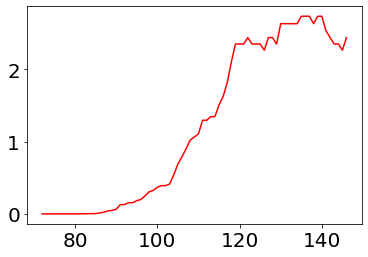

In [104]:
x = rads
y = optimization
plt.plot(x,y,color='r')
        
fig.set_figwidth(50)
fig.set_figheight(15)
plt.show()

Алгоритм екзамену:

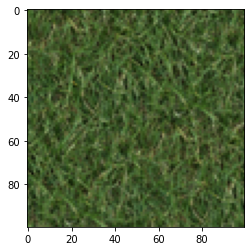

In [25]:
new_img = Image.open('Grass1.jpg')
# bark5 = np.array(new_img)[:300, :300, :]
# bar = Image.fromarray(bark5)
new_img.thumbnail(size)
plt.imshow(new_img)

In [26]:
new_img = np.array(new_img);
admission_top = centers[0] + 41
admission_bottom = centers[0] - 41
new_binary = binearize(new_img, admission_top, admission_bottom)

new_center_hems = np.array([heming(binearized_centers[0],val) for val in new_binary])
result = 0
for val in new_center_hems:
    if val <=  98:
        result += 1
result

0

Висновок: Реагує на кору сірого кольору, бо сірі камені відкидає добре і траву теж відкидає добре <br/>
Спостерігається перенавчання - реагує тільки на навчальне зображення <br/>
Можливі вирішення: подати на вхід більше різних текстур кори. <br/> Подавати текстури взяті квадратними клаптиками. 
<br/> По іншому враховувати RGB при обчисленні відстані Хемінга
<br/> Додати контур оптимізації за контрольними допусками
<br/> Враховуючи те, що в якості реалізацій подаються рядки, а вони не відображають всю сутність структури на зображенні, а також те, як гарно відкидаються реалізації інших класів, робимо висновок, що алгоритм побудови вирішального правила для базового класу обрано досить вірно.

In [44]:
from PIL import Image
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import copy
from sklearn import metrics
import scipy.spatial.distance as dst
import math

In [45]:
N = 100
size = N, N

In [46]:
def heming(arrA, arrB):
    A = arrA.reshape(-1)
    B = arrB.reshape(-1)
    result = 0
    for i,val in enumerate(A.T):
            result += 0 if val == B[i] else 1
    return result       

In [47]:
def k13(rds, h_cntr_rls):
    return len(h_cntr_rls[h_cntr_rls <= rds])

In [48]:
def k24(rds, h_cntr_rls):
    return len(h_cntr_rls[h_cntr_rls > rds])

$ E^{0} = f(N,K_2,K_3),\ \ K_2 = k_2(R^0, [h^{0,1}_1, h^{0,1}_2, ... ]), \ \ K_3 = k_3(R^0, [h^{1,0}_1, h^{1,0}_2, ... ]) $</br>
$ h^{0,1}_n = h([bc^0_1, bc^0_2,\ ... ],\ [b^1_{1,n}, b^1_{2,n},\ ...]), \ \ h^{1,0}_n = h([bc^1_1, bc^1_2,\ ... ],\ [b^0_{1,n}, b^0_{2,n},\ ...]),$</br>
$ b^k_{i,n} = b(\delta_i, s^k_{i,n}) $</br>
Верхній індекс 0 - належність до базового класу </br>
$ E^{0} $ - інформаційний критерій </br>
$ K_2 $ - кількість власних реалізацій, що не потрапили в контейнер базового класу</br>
$ K_3 $ - кількість реалізацій найближчого класу сусіду, що потрапили в контейнер базового класу</br>
$ h^{0,1} $ - відстані Хемінга від центру базового до реалізацій найближчого сусіду </br>
$ h^{1,0} $ - відстані Хемінга від центру найближчого сусіду до реалізацій базового </br>
$ b^k_{i,n} $ - i-та координата бінеаризованої n-тої реалізації k-того класу </br>
$ s^k_{i,n} $ - i-та координата n-тої реалізації k-того класу з навчальної вибірки </br>
$ \delta_i $ - контрольний допуск на i-ту ознаку </br>
$ E^{0} = f(N,R^0,[h^{0,1}_1, h^{0,1}_2,\ ... ], [h^{1,0}_1, h^{1,0}_2,\ ... ]) $

Можна спробувати визначити градієнт $ E^{0} $ з метою реалізації послідовного алгоритму оптимізації контрольних допусків

In [49]:
def kulbak(N,K2,K3):
    K23 = K2 + K3;
    return (1.0/N) * np.log2((2*N + 10.0**(-8) - np.floor(K23)) / (np.floor(K23) + 10.0**(-8))) * round(N - K23,0)

In [50]:
def binearize (image, top, bottom):    
    return np.logical_and(np.greater_equal(top, image), np.greater_equal(image, bottom)).astype(int)

### Реалізовано оптимізацію радіусу контейнера базового класу:

In [51]:
def radius_opt(h_cntr_rls, init_radius):
    radius = init_radius
    result = 0
    best_kulbak = 0
    while radius > h_cntr_rls.min() :
        klbk = kulbak(N, k24(radius, h_cntr_rls[0]), k13(radius, h_cntr_rls[1]))
        if klbk >= best_kulbak :
            best_kulbak = klbk
            result = radius
        radius -= 1
    return (result, best_kulbak)

### Реалізовано паралельну оптимізацію контрольних допусків, визначення параметрів контейнерів, що відділяють у гіперпросторі ознак реалізації відповідного класу від всіх інших, для кожного класу окремо: 

Передбачую, що $\delta$ має обиратися як $\frac 1 2\left(\max\limits_{i,j,k} {x_{i,j}} - \min\limits_{i,j,k} {x_{i,j}}\right) $ або як $\frac 1 2\left(\max\limits_{i,j,k} {x_{i,j}}\right)\ \ \ [ i=0 .. M, j=0 .. N]$

In [52]:
pil_imgs = [Image.open('Bark1.jpg'), 
            Image.open('Stone2.jpg'), 
            Image.open('Grass2.jpg')]
for image in pil_imgs:
    image.thumbnail(size)
    
images = np.array([np.array(val) for val in pil_imgs])

centers = images.mean(axis=1)
d_top = math.ceil(centers.max() / 2)
d_bottom = math.floor(centers.min() / 2)
cont_deltas = []
bin_centers = []
cont_radiuses = []
for z in range(0,images.shape[0]):
    delta = d_top
    best_kulbak, best_delta, best_radius = 0, 0, 0
    best_center = None
    while delta >= d_bottom:
        binary = np.array([binearize(image, centers[z] + delta, centers[z] - delta) for image in images])

        selection = 0.5

        binearized_centers = (binary.mean(axis=1) > selection).astype(int)

        center_hems = np.array([heming(binearized_centers[z],v) for v in np.delete(binearized_centers, z, axis=0)])
        nrst_nhbr = np.where(center_hems == center_hems.min())[0][0]
        center_hems = center_hems[nrst_nhbr]
        
        hems_center_reals = np.array([[np.array([heming(val, realization) for realization in v]) for v in np.take(binary, [z, nrst_nhbr], axis=0)]
                             for val in np.take(binearized_centers, [z, nrst_nhbr], axis=0)])

        maxK0 = hems_center_reals[0,0].max()

        maxK1 = hems_center_reals[1,1].max()

        radiusK0 = maxK0 if maxK0 < center_hems.min() else center_hems.min() - 1
        radiusK1 = maxK1 if maxK1 < center_hems.min() else center_hems.min() - 1

        radius, klbk = radius_opt(hems_center_reals[0], radiusK0);
        if klbk > best_kulbak:
            best_delta = delta
            best_radius = radius
            best_kulbak = klbk
            best_center = binearized_centers[z]
        delta -= 1
    cont_deltas.append(best_delta)
    bin_centers.append(best_center)
    cont_radiuses.append(best_radius)
    print(best_kulbak, best_radius, best_delta)

3.651501615870225 119 36
0.5153324041868461 128 34
7.560258360127304 140 33


In [53]:
binary.shape

(3, 100, 100, 3)

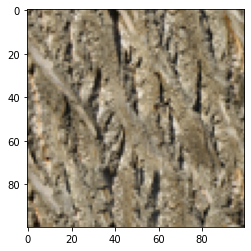

In [41]:
new_img = Image.open('Bark1.jpg')
# bark5 = np.array(new_img)[:300, :300, :]
# bar = Image.fromarray(bark5)
new_img.thumbnail(size)
plt.imshow(new_img)

### Реалізовано алгоритм екзамену:

In [42]:
new_img = np.array(new_img);
for z in range(0,len(cont_deltas)):
    result = 0
    admission_top = centers[z] + cont_deltas[z]
    admission_bottom = centers[z] - cont_deltas[z]
    new_binary = binearize(new_img, admission_top, admission_bottom)

    new_center_hems = np.array([heming(bin_centers[z],val) for val in new_binary])
    result = 0
    for val in new_center_hems:
        if val <=  cont_radiuses[z]:
            result += 1
    print(str(z+1) + " " + str(result))

1 99
2 15
3 0


In [31]:
print(cont_deltas)
print(len(cont_centers))
print(cont_radiuses)

[36, 34, 33]
3
[119, 128, 140]


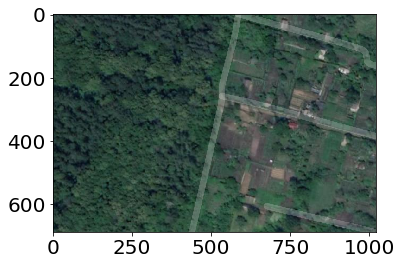

In [411]:
aeroi = Image.open('aero.PNG')
aeroa = np.array(aero);
# new_binary = binearize(new_img, admission_top, admission_bottom)
plt.imshow(aeroi)

In [425]:
aeroa.shape

(687, 1020, 4)

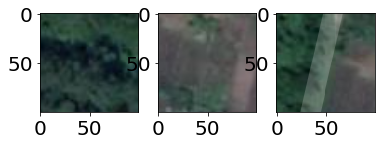

In [552]:
fig, axes = plt.subplots(1,3)
aeros = {'trees' : aeroa[200:200+N,:N,:3],'field' : aeroa[350:350 + N,550:550+N,:3],'road' : aeroa[300:300+N,470:470+N,:3]}
centers = {key : np.mean(val,axis=0)  for key, val in aeros.items()}
axes[0].imshow(aeroa[200:200+N,:N])
axes[1].imshow(aeroa[350:350 + N,550:550+N])
axes[2].imshow(aeroa[300:300+N,470:470+N])

plt.show()

In [553]:
centers = {key : np.mean(image,axis=0) for (key,image) in aeros.items()}
selection = 0.5

delta = N/2
delta_kulbaks = {}
delta_kulbaks.clear()
delta_optimals = {}
delta_optimals.clear()
delta_centers = {}
delta_centers.clear()
while delta > 0 :
    admission_top = centers['trees'] + delta
    admission_bottom = centers['trees'] - delta

    binary = {key : binearize(image, admission_top, admission_bottom)  for (key, image) in aeros.items()}    

    binearized_centers = {key: np.array([np.array(pix > selection, dtype=np.uint8) for pix in np.mean(val, axis=0)]) for (key, val) in binary.items()}

    center_hems = {key: {k : heming(val,v) for k,v in filter(lambda x: key != x[0], binearized_centers.items())}
                       for key, val in binearized_centers.items()}

    hems_center_reals = {key : {k: np.array([heming(val, realization) for realization in v])
                                    for (k, v) in binary.items()} for (key,val) in binearized_centers.items()}

    component = 1

    nrst_neighbr_cntrs = {key : dict(filter(lambda x : center_hems[key][x[0]][component] == 
                                      min(np.array(list(center_hems[key].values()))[:,component])
                                           ,val.items()
                                          )
                                   ) 
                         for key, val in center_hems.items()}

    pairs = {key: list(val.items())[0][0] for key, val in nrst_neighbr_cntrs.items()}

    optimization = kulbak_optimization(hems_center_reals, nrst_neighbr_cntrs, cmpnt=component);

    cont = True
    for v in optimization.values():
        if not bool(v) :
            cont = False
            break

    if cont :
        optimal = {key : dict(
                filter(
                lambda x: val[x[0]] == max(np.array(list(val.values()))) , val.items()
                )
                                 )
                       for key, val in optimization.items()}
        delta_kulbaks[delta] = min([list(val.values())[0] for val in optimal.values()])
        delta_optimals[delta] = {key : list(val.keys())[0] for key, val in optimal.items()}
        delta_centers[delta] = binearized_centers
        
    delta -= 1

array([48.])

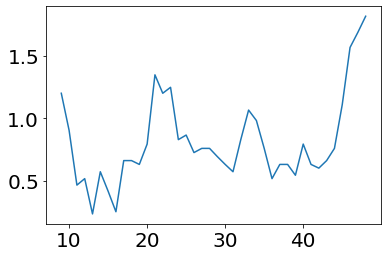

In [554]:
X = np.array(list(delta_kulbaks.keys()))
Y = np.array(list(delta_kulbaks.values()))
plt.plot(X,Y)
opt_delta = X[Y == max(Y)]
opt_delta

trees
field


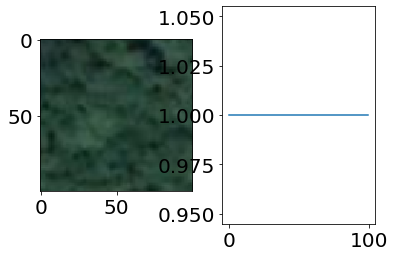

In [560]:
fig, axes = plt.subplots(1,2)
shape = aeroa.shape
ypos = np.random.randint(0,shape[0] - N + 1)
xpos = np.random.randint(0,shape[1] - N + 1)

delta = opt_delta[0]

admission_top = centers['trees'] + delta
admission_bottom = centers['trees'] - delta

new_img = aeroa[ypos:ypos + N,xpos:xpos + N,:3];
new_binary = binearize(new_img, admission_top, admission_bottom)
axes[0].imshow(new_img)

etalon = np.array([np.array(pix > selection, dtype=np.uint8) for pix in np.mean(new_binary, axis=0)])
axes[1].plot(etalon[:,component])

new_center_hems = {key: val for key, val in binearized_centers.items()}
optimal = delta_optimals[delta]

binearized_centers = delta_centers[delta]

for key, val in optimal.items():
    if heming(etalon, binearized_centers[key])[component] <= val :
        print(key)

In [541]:
np.random.randint(1,10)

9